# Breast Cancer dataset & feature selection process

This notebook shows some data selection and engineering processes that may be useful in real world applications.

To classify data, I will use `SGDClassifier`, which was shown to be a pretty robust classifier.

Because the dataset isn't that big, only 569 entries, here is used 10 fold cross validation.

**Feature selection methods:**
- chi2 test, top 5 most important features
- RFECV (recursive feature elimination with cross validation)
- Tree-based method (via `feature_importances_` attribute)
- SelectPercentile with F-test

Beside feature selection, there was used feature engineering methods, polynomial features, and scaling.

**Imports**

In [59]:
from __future__ import print_function

from sklearn import (tree, feature_selection, datasets, cross_validation, ensemble,
                    preprocessing, linear_model, pipeline, grid_search)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.style.use("ggplot")

%matplotlib inline

**Load dataset**

In [2]:
data = datasets.load_breast_cancer()
X = data.data
y = data.target
description = data.DESCR

print(description)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)
        
        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.
 

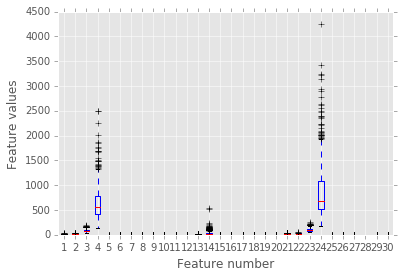

In [3]:
plt.boxplot(X)
plt.xlabel("Feature number")
plt.ylabel("Feature values")
plt.show()

**Correlation test**

Using `chi2` function we are now able to compute the correlation of each feature with the class label.
It means that we can choose specific features that contribute the most to determination wherever a feature vector coresponds to one class or another.

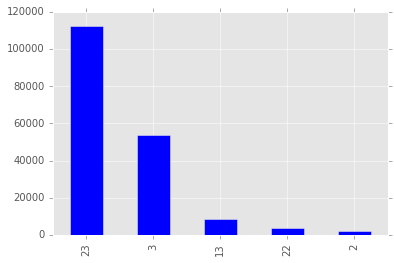

In [4]:
chi_sq = feature_selection.chi2(X, y)
corr_table = pd.DataFrame(zip(*chi_sq), columns = ("Correlation", "P-value"))

top_features = corr_table.sort_values("Correlation", ascending=False).head()

_ = top_features["Correlation"].plot.bar()

**[OPTIONAL] Scaling**

In [5]:
use_scaling = False

X_scaled = preprocessing.scale(X)

if use_scaling == True and X.all() != X_scaled.all():
    X = X_scaled
    print("WARNING!!! X was scaled.")

**[OPTIONAL] Polynomial features**

In [6]:
extend = False

X_extended = preprocessing.PolynomialFeatures().fit_transform(X)

print(X_extended.shape)

if extend == True and X.all() != X_extended.all():
    X = X_extended
    print("WARNING!!! X was extended with polynomial features.")

(569, 496)


**10 fold Cross Validation**

In [7]:
kfcv = cross_validation.KFold(len(y), n_folds = 10, shuffle = True)

**Vanila SGD Liniar Classfier**

No feature selection technique applied.

In [8]:
vanila_sgd = linear_model.SGDClassifier(n_iter=1000, n_jobs=3)
scores = [vanila_sgd.fit(X[train], y[train]).score(X[test], y[test]) for train, test in kfcv]

rows, cols = X.shape
print((rows, cols))
print("Matrix size: {0} elements.".format(rows * cols))
print("Accuracy of vanila_sgd is {0}".format(sum(scores) / kfcv.n_folds))

(569, 30)
Matrix size: 17070 elements.
Accuracy of vanila_sgd is 0.906860902256


**SGD + chi squared**

After choosing 5 most important features we got a 6 fold reduction in size, keeping the most informative features.

In [9]:
indices = top_features.to_dense().index.get_values()

X_reduced = X[:, indices]

chi2_sgd = linear_model.SGDClassifier(n_iter=1000, n_jobs=3)
scores = [chi2_sgd.fit(X_reduced[train], y[train]).score(X_reduced[test], y[test]) for train, test in kfcv]

rows, cols = X_reduced.shape
print((rows, cols))
print("Matrix size: {0} elements.".format(rows * cols))
print("Accuracy of chi2_sgd is {0}".format(sum(scores) / kfcv.n_folds))

(569, 5)
Matrix size: 2845 elements.
Accuracy of chi2_sgd is 0.91212406015


**SGD + Recursive Feature Elimination (RFE)**

In [10]:
_sgd = linear_model.SGDClassifier(n_iter = 100)
rfecv = feature_selection.RFECV(_sgd, cv = 10, scoring = "accuracy")

rfecv.fit(X, y)

rfe_sgd = linear_model.SGDClassifier(n_iter=1000, n_jobs=3)
print(rfecv.n_features_)

X_new = rfecv.transform(X)

scores = [rfe_sgd.fit(X_new[train], y[train]).score(X_new[test], y[test]) for train, test in kfcv]

rows, cols = X_new.shape
print((rows, cols))
print("Matrix size: {0} elements.".format(rows * cols))
print("Accuracy of rfecv_sgd is {0}".format(sum(scores) / kfcv.n_folds))

26
(569, 26)
Matrix size: 14794 elements.
Accuracy of rfecv_sgd is 0.894360902256


**SGD + Tree Feature Selection**

In [11]:
feature_importance_tree = tree.DecisionTreeClassifier()
feature_importance_tree.fit(X, y)

feature_importance_list = feature_importance_tree.feature_importances_.tolist()
indices = zip(*sorted(enumerate(feature_importance_list), key=lambda x: x[1], reverse=True)[:5])[0]

X_tree = X[:, indices]

tree_sgd = linear_model.SGDClassifier(n_iter=1000, n_jobs=3)
scores = [tree_sgd.fit(X_tree[train], y[train]).score(X_tree[test], y[test]) for train, test in kfcv]

rows, cols = X_tree.shape
print((rows, cols))
print("Matrix size: {0} elements.".format(rows * cols))
print("Accuracy of tree_sgd is {0}".format(sum(scores) / kfcv.n_folds))

(569, 5)
Matrix size: 2845 elements.
Accuracy of tree_sgd is 0.934993734336


**SGD + SelectPercentile**

In [12]:
selector = feature_selection.SelectPercentile(percentile=50)

X_selected = selector.fit_transform(X, y)

selector_sgd = linear_model.SGDClassifier(n_iter=1000, n_jobs=3)
scores = [selector_sgd.fit(X_selected[train], y[train]).score(X_selected[test], y[test]) for train, test in kfcv]

rows, cols = X_selected.shape
print((rows, cols))
print("Matrix size: {0} elements.".format(rows * cols))
print("Accuracy of selector_sgd is {0}".format(sum(scores) / kfcv.n_folds))

(569, 15)
Matrix size: 8535 elements.
Accuracy of selector_sgd is 0.857550125313


In [77]:
pipe = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("feature_selector", feature_selection.SelectFromModel(tree.DecisionTreeClassifier(), threshold=0.0002)),
        ("estimator", linear_model.SGDClassifier(alpha=0.001, l1_ratio=0.005, n_iter=1000))
    ])

scores = [pipe.fit(X[train], y[train]).score(X[test], y[test]) for train, test in kfcv]

print(sum(scores) / kfcv.n_folds)

0.970112781955


In [64]:
params = {
    "estimator__l1_ratio": np.logspace(0, -3, 5),
    "estimator__alpha": np.logspace(-3, -5, 10),
    "feature_selector__threshold": np.logspace(1, -4, 10)
}

grid = grid_search.GridSearchCV(pipe, params, cv=10, n_jobs=4)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

# Conclusion

As usual, feature scaling/normalization is very important. After numerous experiments, it can be said that it is maybe the most important preprocessing stage. <br/>
The most stable feature selection method seems to be the tree based one. The resulting accuracy is high (~0.97) and what is more important, is relatively stable. Also, it is one of the fastest methods.

**Note** The notebook is a bit messy, maybe I'll prettify it some time, more important are the insights that I gained from it.